In [ ]:
# check channels
# time window
# beta values for Adam
import os
raw_data_dir = ''
acc_key = 'acc'
plot_examples = False # notebook file size will increase by between 30 and 60MB if set to True; <1MB otherwise

if  'COLAB_GPU' in os.environ :
    print('Using Google Colab. Setting up environment')
    raw_data_dir = '/content/drive/My Drive/Colab Notebooks/' 
    !pip install mne==0.19.2
    !pip install pyedflib==0.1.15
    print('\n \n To load files from Google Drive, account validation is required.')
    # mount to drive -- files should be located in the /Colab Notebooks directory
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    
    # download project utilities and data reader 
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/ReadData
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/MLModels/utils

elif 'KAGGLE_URL_BASE' in os.environ:
    acc_key = 'accuracy'
    print('Using Kaggle kernel. Setting up environment')
    !pip install update mne==0.19.2
    !pip install pyedflib==0.1.15
    !pip install chart_studio
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/Data/Raw
    raw_data_dir = 'Raw/'
    
    # download project utilities and data reader 
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/ReadData
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/MLModels/utils Utils


else: 
    # assuming that a local run will be launched only from a github project; 
    # add the utils and ReadData directories to the temporary path
    if 'HOMEPATH' in os.environ:
        print('Using homepath ' + os.environ['HOMEPATH'])
    raw_data_dir = '../../Data/Raw/'
    
    from pathlib import Path
    import sys
    sys.path.append(os.path.realpath('..'))
    path = Path(os.getcwd())
    sys.path.append(str(path.parent.parent))


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, AveragePooling2D, AveragePooling1D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm

import pandas as pd
import numpy as np
import random 

from importlib import reload  #reload(chart_builder)


#################
# import project utilities and the raw data reader
# Kaggle environment does not accept 'utils' as a file, so it must be accessed seperately

import ReadData.RawDataReader as data_reader
if 'KAGGLE_URL_BASE' in os.environ:
    import Utils.ModelBuilder as model_builder
    import Utils.ChartBuilder as chart_builder
else:
    import utils.ModelBuilder as model_builder
    import utils.ChartBuilder as chart_builder


In [ ]:
ignore_list = ['s12', 's14']  # List of patient files that should be skipped
resolution_hz = 250 # Hz resolution - number of frames per second; 250Hz is the selected value for the EEG dataset
time_window = resolution_hz * 20 # Seconds of data to include in one slice;

all_channels = ['Fp2', 'F8', 'T4', 'T6', 'O2', 'Fp1', 'F7', 'T3', 'T5', 'O1', 'F4',
                'C4', 'P4', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz']
excluded_channels = [ 'T3', 'T5', 'T6', 'O1', 'F3', 'Fp1', 'Fp2', 'P4']#F8'
excluded_channels = []

chans = len(all_channels) - len(excluded_channels)
data = data_reader.get_raw_data(raw_data_dir, resolution_hz, ignore_list, 
                                excluded_channels, time_window)
#np.save('data', data)

In [21]:
if plot_examples:
    random_selection =  data_reader.get_random_participants(raw_data_dir, data, ignore_list, resolution_hz)
    chart_builder.plot_random_participants(data, ignore_list, excluded_channels, all_channels, random_selection)


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Create the /tmp directory if it doesn't already exist
import os
if not os.path.exists('tmp'):
    os.makedirs('tmp')


def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true)))


# Construct a learning rate scheduler such that the lr is decreased when the loss remains unchanged after 4 epochs
# Adapted from
# https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self, minimum_learning_rate):
        self.losses = []
        self.lr = []
        self.last_loss_improvement = None
        self.loss_unchanged_count = 0
        self.minimum_learning_rate = minimum_learning_rate

    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        self.last_loss_improvement = 1.0
        self.loss_unchanged_count = 0

    def on_epoch_end(self, batch, logs={}):
        epoch_loss = logs.get('val_loss')
        # track if losses are being updated
        if (len(self.losses) > 1) and ((epoch_loss == self.losses[-1]) or (epoch_loss > self.last_loss_improvement)):
            self.loss_unchanged_count += 1
        else:
            self.loss_unchanged_count = 0
            self.last_loss_improvement = epoch_loss

        self.losses.append(epoch_loss)

    # Implement the lr_loss_scheduler within the class so that it can access loss_unchanged_count
    def on_epoch_begin(self, batch,
                       logs={}):
        current_lr = K.get_value(self.model.optimizer.lr)
        lr = current_lr - (current_lr / 4)  # propose to decrement lr by 25% of current value
        if self.loss_unchanged_count > 3 and lr >= self.minimum_learning_rate:
            self.loss_unchanged_count = 0  # reset
            K.set_value(self.model.optimizer.lr, lr)  # set for the model
            print('Updated learning rate to ', lr)
            # return K.get_value(self.model.optimizer.lr)


# List all data in history
# print(fitted_model.history.keys())


# Function to display important model metrics. Namely, Accuracy, Root Mean Square Error and loss
# accuracy key for the fitted model history is different for Kaggle environment
def print_model_metrics(fitted_model, acc_key):
    print('Diagrammed History of Model Metrics')

    # summarize history for accuracy
    plt.plot(fitted_model.history[acc_key])
    plt.plot(fitted_model.history['val_' + acc_key])
    plt.title('Model Accuracy over Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # summarize history for RMSE
    plt.plot(fitted_model.history['rmse'])
    plt.plot(fitted_model.history['val_rmse'])
    plt.title('Model Root Mean Square Error over Epochs')
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # summarize loss history
    plt.plot(fitted_model.history['loss'])
    plt.plot(fitted_model.history['val_loss'])
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


def construct_and_run_model(data, model, optimizer, checkpoint_file_name, epochs=150,
                            batch_size=64, loss_type='categorical_crossentropy',
                            metrics=['accuracy', rmse], minimum_learning_rate=10.e-6):  # 'mse', 'mae', ):
    loss_history = LossHistory(minimum_learning_rate)

    # compile the model and set the optimizers
    model.compile(loss=loss_type, optimizer=optimizer,
                  metrics=metrics)

    model.summary()

    # count number of parameters in the model
    numParams = model.count_params()

    # set a valid path for your system to record model checkpoints
    checkpointer = ModelCheckpoint(filepath=checkpoint_file_name, verbose=1,
                                   save_best_only=True)

    # change_lr = tensorflow.keras.callbacks.LearningRateScheduler(lr_loss_scheduler)

    fitted_model = model.fit(data['X_train'], data['Y_train'], batch_size=batch_size, epochs=epochs,
                             verbose=2, validation_data=(data['X_validate'], data['Y_validate']),
                             callbacks=[checkpointer, loss_history])

    model.load_weights(checkpoint_file_name)

    probs = model.predict(data['X_test'])
    preds = probs.argmax(axis=-1)
    acc = np.mean(preds == data['Y_test'].argmax(axis=-1))
    print("Classification accuracy: %f " % acc)
    return fitted_model





In [27]:
from tensorflow.keras import layers
from keras.regularizers import l2


def LSTM(time_steps, nb_features, chans, nb_classes):

    model=tf.keras.Sequential()
    
    print('chans: ', chans)
    print('nb_features: ', nb_features)

    units = 90
    dropout_rate = 0.002 * units if units < 100 else 0.15

    #model.add(Bidirectional(layers.LSTM(units,
    #                             dropout = dropout_rate),
    #                                                         input_shape=( time_steps, chans)
    #))
    
    model.add(layers.LSTM(units,
                          input_shape=( time_steps, chans),
                          dropout = dropout_rate,
                          #recurrent_regularizer=l2(0.01), 
                          bias_regularizer=l2(0.01)
                         # return_sequences=True
            ))
    #model.add(Bidirectional(layers.LSTM(math.floor(units/2),
    #                             dropout = dropout_rate/2)))
    #
    model.add(Dense(4,kernel_initializer='he_uniform',activation='relu'))
    

    model.add(Dense(nb_classes,activation='softmax'))
    
    return model

In [28]:
####LSTM

#declare model, optimizer and checkpoint file
model = LSTM(time_steps=time_window, chans=chans, nb_features=1, nb_classes=2 )

opt_adam = tf.keras.optimizers.Adam(lr=0.00004, 
                                beta_1=0.99,
                                beta_2=0.999,
                                epsilon=1e-07)
sgd = tf.keras.optimizers.SGD(lr=0.01)

lstm_checkpoint = '/tmp/LSTM_checkpoint.h5'

fitted_model_lstm = construct_and_run_model(data, model, opt_adam, lstm_checkpoint, epochs=300, batch_size=32)
#fitted_model_lstm = model_builder.construct_and_run_model(data, model, opt_adam, lstm_checkpoint, epochs=200, batch_size=32)


chans:  19
nb_features:  1
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 90)                39600     
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 364       
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 10        
Total params: 39,974
Trainable params: 39,974
Non-trainable params: 0
_________________________________________________________________
Train on 450 samples, validate on 100 samples
Epoch 1/300

Epoch 00001: val_loss improved from inf to 1.60960, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 5s - loss: 1.5926 - accuracy: 0.5289 - rmse: 0.4964 - val_loss: 1.6096 - val_accuracy: 0.5000 - val_rmse: 0.5143
Epoch 2/300

Epoch 00002: val_loss improved from 1.60960 to 1.60824, saving mo

Epoch 33/300

Epoch 00033: val_loss improved from 1.55036 to 1.54833, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.5411 - accuracy: 0.6044 - rmse: 0.4894 - val_loss: 1.5483 - val_accuracy: 0.5700 - val_rmse: 0.5024
Epoch 34/300

Epoch 00034: val_loss improved from 1.54833 to 1.54626, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 3s - loss: 1.5358 - accuracy: 0.6200 - rmse: 0.4905 - val_loss: 1.5463 - val_accuracy: 0.5600 - val_rmse: 0.5020
Epoch 35/300

Epoch 00035: val_loss improved from 1.54626 to 1.54411, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 3s - loss: 1.5328 - accuracy: 0.6067 - rmse: 0.4891 - val_loss: 1.5441 - val_accuracy: 0.5600 - val_rmse: 0.5017
Epoch 36/300

Epoch 00036: val_loss improved from 1.54411 to 1.54199, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.5310 - accuracy: 0.6133 - rmse: 0.4871 - val_loss: 1.5420 - val_accuracy: 0.5600 - val_rmse: 0.5013
Epoch 37/300

Epoch 00037: val_loss improved from 1.54199 to 1.53990

Epoch 69/300

Epoch 00069: val_loss improved from 1.46315 to 1.45964, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.4671 - accuracy: 0.6311 - rmse: 0.4756 - val_loss: 1.4596 - val_accuracy: 0.5900 - val_rmse: 0.4829
Epoch 70/300

Epoch 00070: val_loss improved from 1.45964 to 1.45610, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.4586 - accuracy: 0.6556 - rmse: 0.4645 - val_loss: 1.4561 - val_accuracy: 0.6000 - val_rmse: 0.4818
Epoch 71/300

Epoch 00071: val_loss improved from 1.45610 to 1.45256, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.4603 - accuracy: 0.6356 - rmse: 0.4732 - val_loss: 1.4526 - val_accuracy: 0.6000 - val_rmse: 0.4808
Epoch 72/300

Epoch 00072: val_loss improved from 1.45256 to 1.44908, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.4565 - accuracy: 0.6578 - rmse: 0.4656 - val_loss: 1.4491 - val_accuracy: 0.6000 - val_rmse: 0.4798
Epoch 73/300

Epoch 00073: val_loss improved from 1.44908 to 1.44538

Epoch 105/300

Epoch 00105: val_loss improved from 1.29587 to 1.29290, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.3438 - accuracy: 0.7289 - rmse: 0.4244 - val_loss: 1.2929 - val_accuracy: 0.7500 - val_rmse: 0.4255
Epoch 106/300

Epoch 00106: val_loss improved from 1.29290 to 1.28970, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.3378 - accuracy: 0.7156 - rmse: 0.4354 - val_loss: 1.2897 - val_accuracy: 0.7600 - val_rmse: 0.4241
Epoch 107/300

Epoch 00107: val_loss improved from 1.28970 to 1.28634, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.3331 - accuracy: 0.7067 - rmse: 0.4277 - val_loss: 1.2863 - val_accuracy: 0.7600 - val_rmse: 0.4224
Epoch 108/300

Epoch 00108: val_loss improved from 1.28634 to 1.28308, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.3329 - accuracy: 0.7156 - rmse: 0.4340 - val_loss: 1.2831 - val_accuracy: 0.7600 - val_rmse: 0.4208
Epoch 109/300

Epoch 00109: val_loss improved from 1.28308 to 1.


Epoch 00140: val_loss improved from 1.23190 to 1.23038, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.2812 - accuracy: 0.7489 - rmse: 0.4231 - val_loss: 1.2304 - val_accuracy: 0.7800 - val_rmse: 0.4085
Epoch 141/300

Epoch 00141: val_loss improved from 1.23038 to 1.22894, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.2742 - accuracy: 0.7733 - rmse: 0.4194 - val_loss: 1.2289 - val_accuracy: 0.7800 - val_rmse: 0.4079
Epoch 142/300

Epoch 00142: val_loss improved from 1.22894 to 1.22730, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.2842 - accuracy: 0.7222 - rmse: 0.4161 - val_loss: 1.2273 - val_accuracy: 0.7800 - val_rmse: 0.4069
Epoch 143/300

Epoch 00143: val_loss improved from 1.22730 to 1.22563, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.2747 - accuracy: 0.7356 - rmse: 0.4205 - val_loss: 1.2256 - val_accuracy: 0.7800 - val_rmse: 0.4058
Epoch 144/300

Epoch 00144: val_loss improved from 1.22563 to 1.22409, saving 

Epoch 176/300

Epoch 00176: val_loss improved from 1.18252 to 1.18115, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.2426 - accuracy: 0.7356 - rmse: 0.4233 - val_loss: 1.1812 - val_accuracy: 0.8100 - val_rmse: 0.3930
Epoch 177/300

Epoch 00177: val_loss improved from 1.18115 to 1.17981, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.2344 - accuracy: 0.7556 - rmse: 0.4180 - val_loss: 1.1798 - val_accuracy: 0.8100 - val_rmse: 0.3932
Epoch 178/300

Epoch 00178: val_loss improved from 1.17981 to 1.17871, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.2192 - accuracy: 0.7844 - rmse: 0.4100 - val_loss: 1.1787 - val_accuracy: 0.8000 - val_rmse: 0.3940
Epoch 179/300

Epoch 00179: val_loss improved from 1.17871 to 1.17782, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.2246 - accuracy: 0.7467 - rmse: 0.4117 - val_loss: 1.1778 - val_accuracy: 0.8100 - val_rmse: 0.3950
Epoch 180/300

Epoch 00180: val_loss improved from 1.17782 to 1.


Epoch 00211: val_loss improved from 1.13888 to 1.13745, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.1806 - accuracy: 0.7533 - rmse: 0.4031 - val_loss: 1.1375 - val_accuracy: 0.8100 - val_rmse: 0.3807
Epoch 212/300

Epoch 00212: val_loss improved from 1.13745 to 1.13612, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.1801 - accuracy: 0.7844 - rmse: 0.3999 - val_loss: 1.1361 - val_accuracy: 0.8100 - val_rmse: 0.3800
Epoch 213/300

Epoch 00213: val_loss improved from 1.13612 to 1.13486, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.1748 - accuracy: 0.7800 - rmse: 0.3808 - val_loss: 1.1349 - val_accuracy: 0.8100 - val_rmse: 0.3791
Epoch 214/300

Epoch 00214: val_loss improved from 1.13486 to 1.13369, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.1755 - accuracy: 0.7600 - rmse: 0.3746 - val_loss: 1.1337 - val_accuracy: 0.8100 - val_rmse: 0.3780
Epoch 215/300

Epoch 00215: val_loss improved from 1.13369 to 1.13255, saving 

Epoch 247/300

Epoch 00247: val_loss improved from 1.10124 to 1.09990, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.1361 - accuracy: 0.7844 - rmse: 0.3783 - val_loss: 1.0999 - val_accuracy: 0.7700 - val_rmse: 0.3608
Epoch 248/300

Epoch 00248: val_loss improved from 1.09990 to 1.09830, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.1360 - accuracy: 0.7867 - rmse: 0.3705 - val_loss: 1.0983 - val_accuracy: 0.7900 - val_rmse: 0.3636
Epoch 249/300

Epoch 00249: val_loss improved from 1.09830 to 1.09664, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.1348 - accuracy: 0.7667 - rmse: 0.3935 - val_loss: 1.0966 - val_accuracy: 0.8200 - val_rmse: 0.3669
Epoch 250/300

Epoch 00250: val_loss improved from 1.09664 to 1.09520, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.1240 - accuracy: 0.7822 - rmse: 0.3989 - val_loss: 1.0952 - val_accuracy: 0.8200 - val_rmse: 0.3684
Epoch 251/300

Epoch 00251: val_loss improved from 1.09520 to 1.


Epoch 00282: val_loss improved from 1.06940 to 1.06877, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.0904 - accuracy: 0.7889 - rmse: 0.3698 - val_loss: 1.0688 - val_accuracy: 0.7900 - val_rmse: 0.3515
Epoch 283/300

Epoch 00283: val_loss improved from 1.06877 to 1.06799, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.0878 - accuracy: 0.8244 - rmse: 0.3537 - val_loss: 1.0680 - val_accuracy: 0.7900 - val_rmse: 0.3512
Epoch 284/300

Epoch 00284: val_loss improved from 1.06799 to 1.06709, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.0888 - accuracy: 0.8000 - rmse: 0.3706 - val_loss: 1.0671 - val_accuracy: 0.7900 - val_rmse: 0.3515
Epoch 285/300

Epoch 00285: val_loss improved from 1.06709 to 1.06623, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 1.0893 - accuracy: 0.7956 - rmse: 0.3780 - val_loss: 1.0662 - val_accuracy: 0.7900 - val_rmse: 0.3517
Epoch 286/300

Epoch 00286: val_loss improved from 1.06623 to 1.06532, saving 

Diagrammed History of Model Metrics


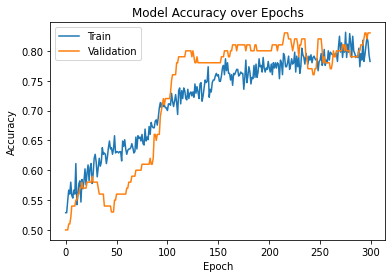

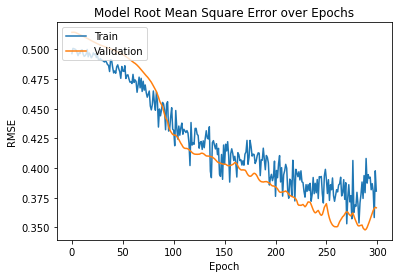

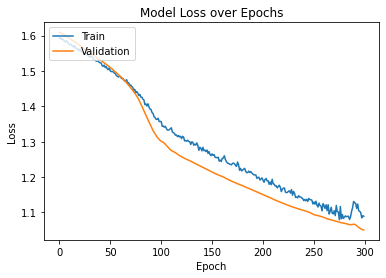

In [29]:
model_builder.print_model_metrics(fitted_model_lstm, acc_key)


In [ ]:
tensorflow==2.1.0


In [ ]:
!pip freeze

In [ ]:
from platform import python_version

print(python_version())